##### Load dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

import ipywidgets as widgets
from ipywidgets import VBox
from ipywidgets import HBox, Label
from IPython.display import display, clear_output

from cil.framework import DataContainer #,AcquisitionData
from cil.utilities.display import show_geometry, show2D
from cil.utilities.jupyter import islicer
from cil.io import NikonDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, RingRemover
from cil.recon import FDK
from cil.optimisation.algorithms import CGLS, SIRT
from cil.optimisation.utilities import callbacks

##### Load the data

Specify the parent directory and list the scans

In [2]:
# Specify the parent directory
parent_directory = "data"

# Make sure the directory exists
if not os.path.isdir(parent_directory):
    raise IOError(parent_directory + " is not a directory.")
    
# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.xtekct'))

# Make sure the directory contains a single xtekct file
if len(files) == 0:
    raise IOError(parent_directory + " is a directory but it does not contain any xtekct file.")

if len(files) > 1:
    print("WARNING:", parent_directory + " is a directory but it contains several xtekct files. The first one", files[0], "will be used by default.")


for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))

0: data/NXCT0462-AG_SD-card_8gb_Al4.xtekct


choose the number of the file in the files list 

In [3]:
file_menu = widgets.Dropdown(
    options=files,
    value=files[0],
    description='File:',
    disabled=False,
)
file_menu

Dropdown(description='File:', options=('data/NXCT0462-AG_SD-card_8gb_Al4.xtekct',), value='data/NXCT0462-AG_SD…

In [4]:
filename = file_menu.value

In [5]:
use_binning_checkbox = widgets.Checkbox(
    value=False,
    description='Use binning',
    disabled=False,
    indent=False
);

binning_xy_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    orientation='horizontal',
    readout=True,
    readout_format='d'
);

binning_z_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    orientation='horizontal',
    readout=True,
    readout_format='d'
);

binning_xy_label = Label('Binning along the X- & Y-axes:');

binning_z_label = Label('Binning along the Z-axis:');

layout = widgets.Layout(width='600px')

out_vbox = VBox(children=[
        HBox([binning_xy_label, binning_xy_slider]),
        HBox([binning_z_label, binning_z_slider]),
    ]);

if use_binning_checkbox.value == False:
    out_vbox.layout.visibility = 'hidden'

out = widgets.Output()

def on_value_change(change):
    with out:
        if use_binning_checkbox.value:
            out_vbox.layout.visibility = 'visible'
            
        else:
            out_vbox.layout.visibility = 'hidden'

        clear_output()
        
    out_vbox.children=[
        HBox([Label('Binning along the X- & Y-axes:'), binning_xy_slider]),
        HBox([Label('Binning along the Z-axis:'), binning_z_slider])
    ];

use_binning_checkbox.observe(on_value_change, names='value')

HBox(children=[use_binning_checkbox, out_vbox])

In [6]:
# Instanciate the reader
if use_binning_checkbox:
    reader = NikonDataReader(file_name=filename, roi= {'horizontal':(None, None, binning_xy_slider.value),'vertical':(None, None, binning_xy_slider.value),'angle':(None, None, binning_z_slider.value)}, mode="bin");
else:
    reader = NikonDataReader(file_name=filename);
    
# Read the data
data = reader.read()

In [7]:
# Inspect the geometry
print(data.geometry);

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -70.34352,   0.     ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 901.39248,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [798 574]
	Pixel size: [0.508 0.508]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [14.332703  , 12.332336  , 10.331955  ,  8.331589  ,  6.3312225 ,
  4.330841  ,  2.3304749 ,  0.33010864, -1.6702576 , -3.670639  ]
	Angles 170-179 in degrees: [-325.73038, -327.73074, -329.7311 , -331.73148, -333.7318 , -335.73218,
 -337.7326 , -339.73297, -341.73334, -343.7337 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


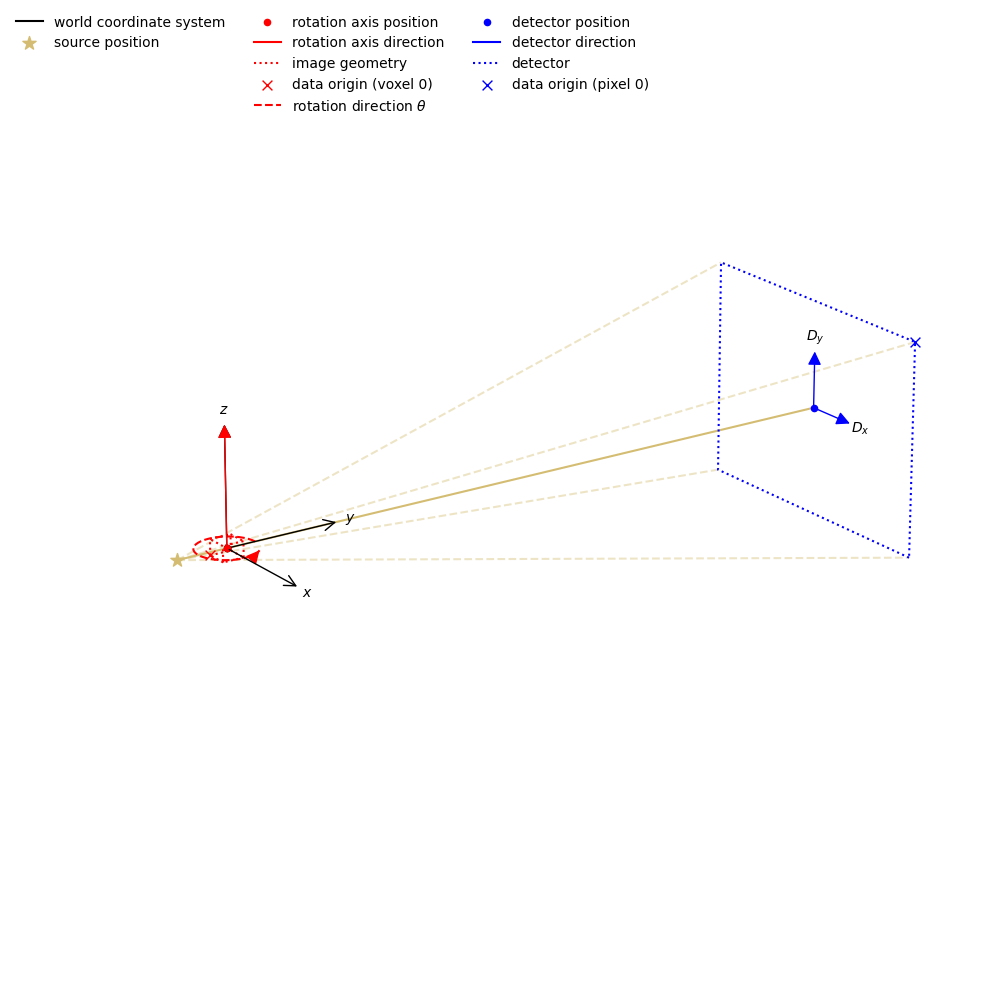

Saved image as /home/fpvidal/PROGRAMMING/GitHub/CCPi-Users-NXCT-Manchester/data/geometry.png


<Figure size 640x480 with 0 Axes>

In [8]:
# Plot and save the geometry
fname = os.path.join(parent_directory, "geometry.png");
show_geometry(data.geometry).save(fname);

In [9]:
# Inspect the projections
islicer(data, direction='angle', origin="upper-left");

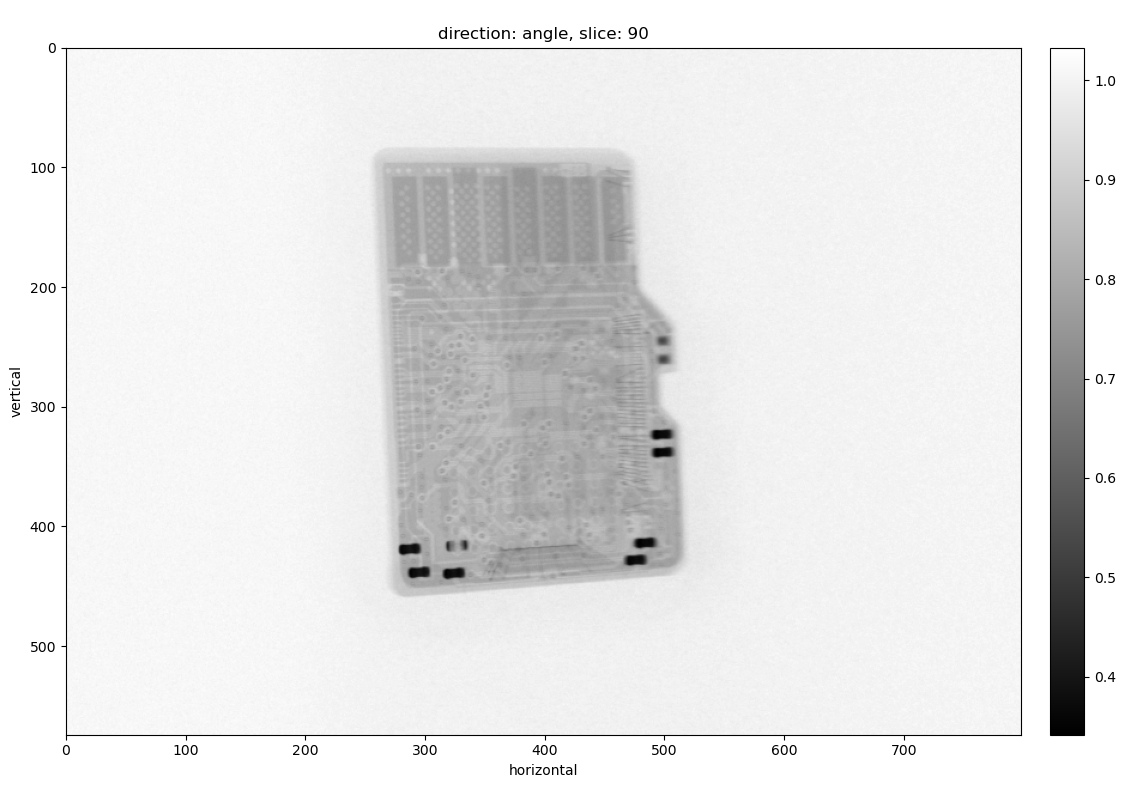

In [10]:
show2D(data, origin="upper-left");

##### Normalise using $-\ln\left(\frac{data}{white\_level}\right)$

##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

In [11]:
data_corr = TransmissionAbsorptionConverter(min_intensity=0.00001, white_level=data.max())(data);

Plot the sinogram of the centre slice using show2D

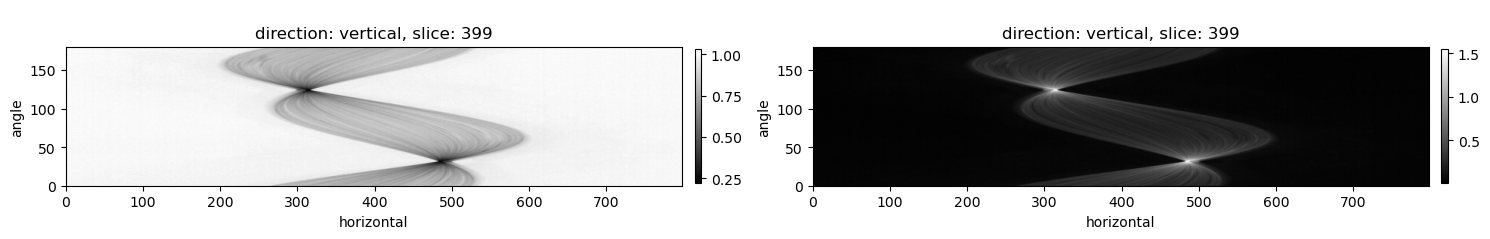

In [12]:
show2D([data, data_corr], slice_list=('vertical', data.shape[2] // 2))

##### Get a vertical slice of the data

##### Filtered back projection

We use the CIL filtered back projection. By default this uses a Ram-Lak

In [13]:
data_slice = data_corr.get_slice(vertical="centre")

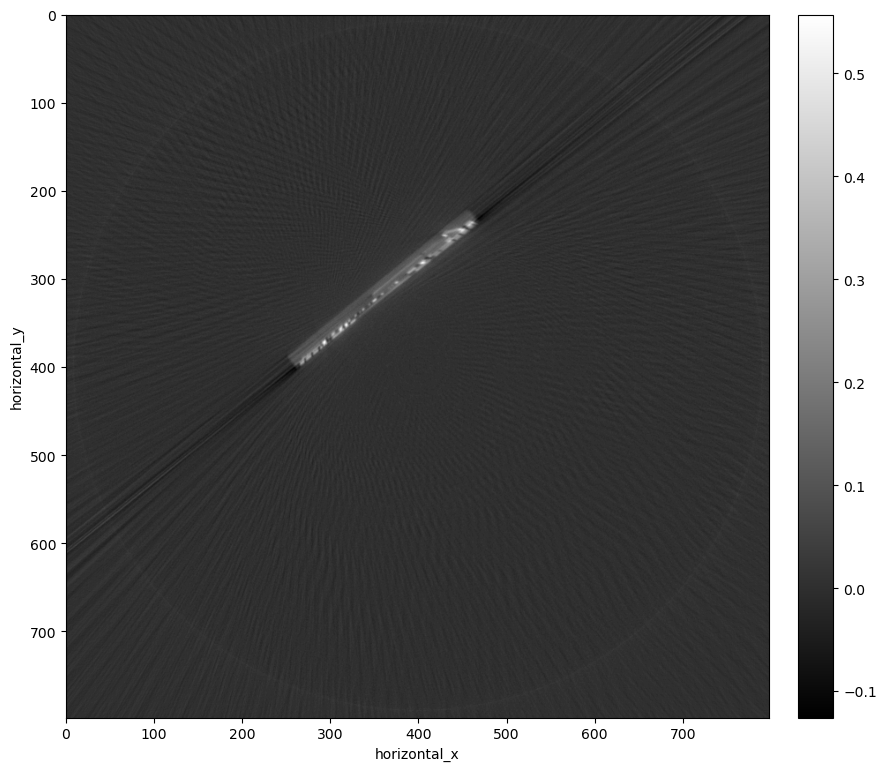

In [14]:
ig = data_slice.geometry.get_ImageGeometry();
recons_FDK_before = FDK(data_slice, ig).run(verbose=False)
show2D(recons_FDK_before, origin="upper-left")

In [15]:
voxel_num_x_slider = widgets.IntSlider(
    value=ig.voxel_num_x,
    min=1,
    max=ig.voxel_num_x,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

voxel_num_y_slider = widgets.IntSlider(
    value=ig.voxel_num_y,
    min=1,
    max=ig.voxel_num_y,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

voxel_num_z_slider = widgets.IntSlider(
    value=data.shape[1],
    min=1,
    max=data.shape[1],
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Box(children=[voxel_num_x, voxel_num_y, voxel_num_z])
VBox(children=[
    HBox([Label('Number of voxels along the X-axis:'), voxel_num_x_slider]),
    HBox([Label('Number of voxels along the Y-axis:'), voxel_num_y_slider]),
    HBox([Label('Number of voxels along the Z-axis:'), voxel_num_z_slider])
])

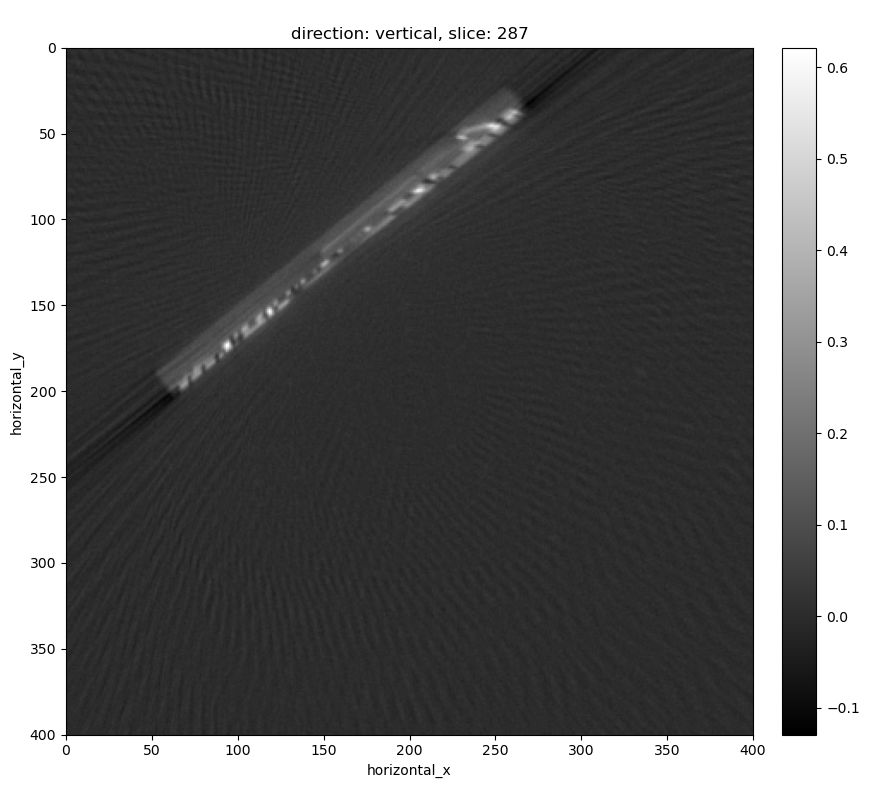

In [16]:
# Define a ROI to reconstruct the 3 middle slices only
ig = data_corr.geometry.get_ImageGeometry();
ig.voxel_num_x = voxel_num_x_slider.value
ig.voxel_num_y = voxel_num_y_slider.value
ig.voxel_num_z = voxel_num_z_slider.value

reco_before = FDK(data_corr, ig).run(verbose=False)
show2D(reco_before, origin="upper-left")

In [17]:
islicer(reco_before, origin="upper-left")

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

In [18]:
processor = CentreOfRotationCorrector.image_sharpness(slice_index='centre', tolerance=1/125)
processor.set_input(data_corr)
processor.get_output(out=data_corr)

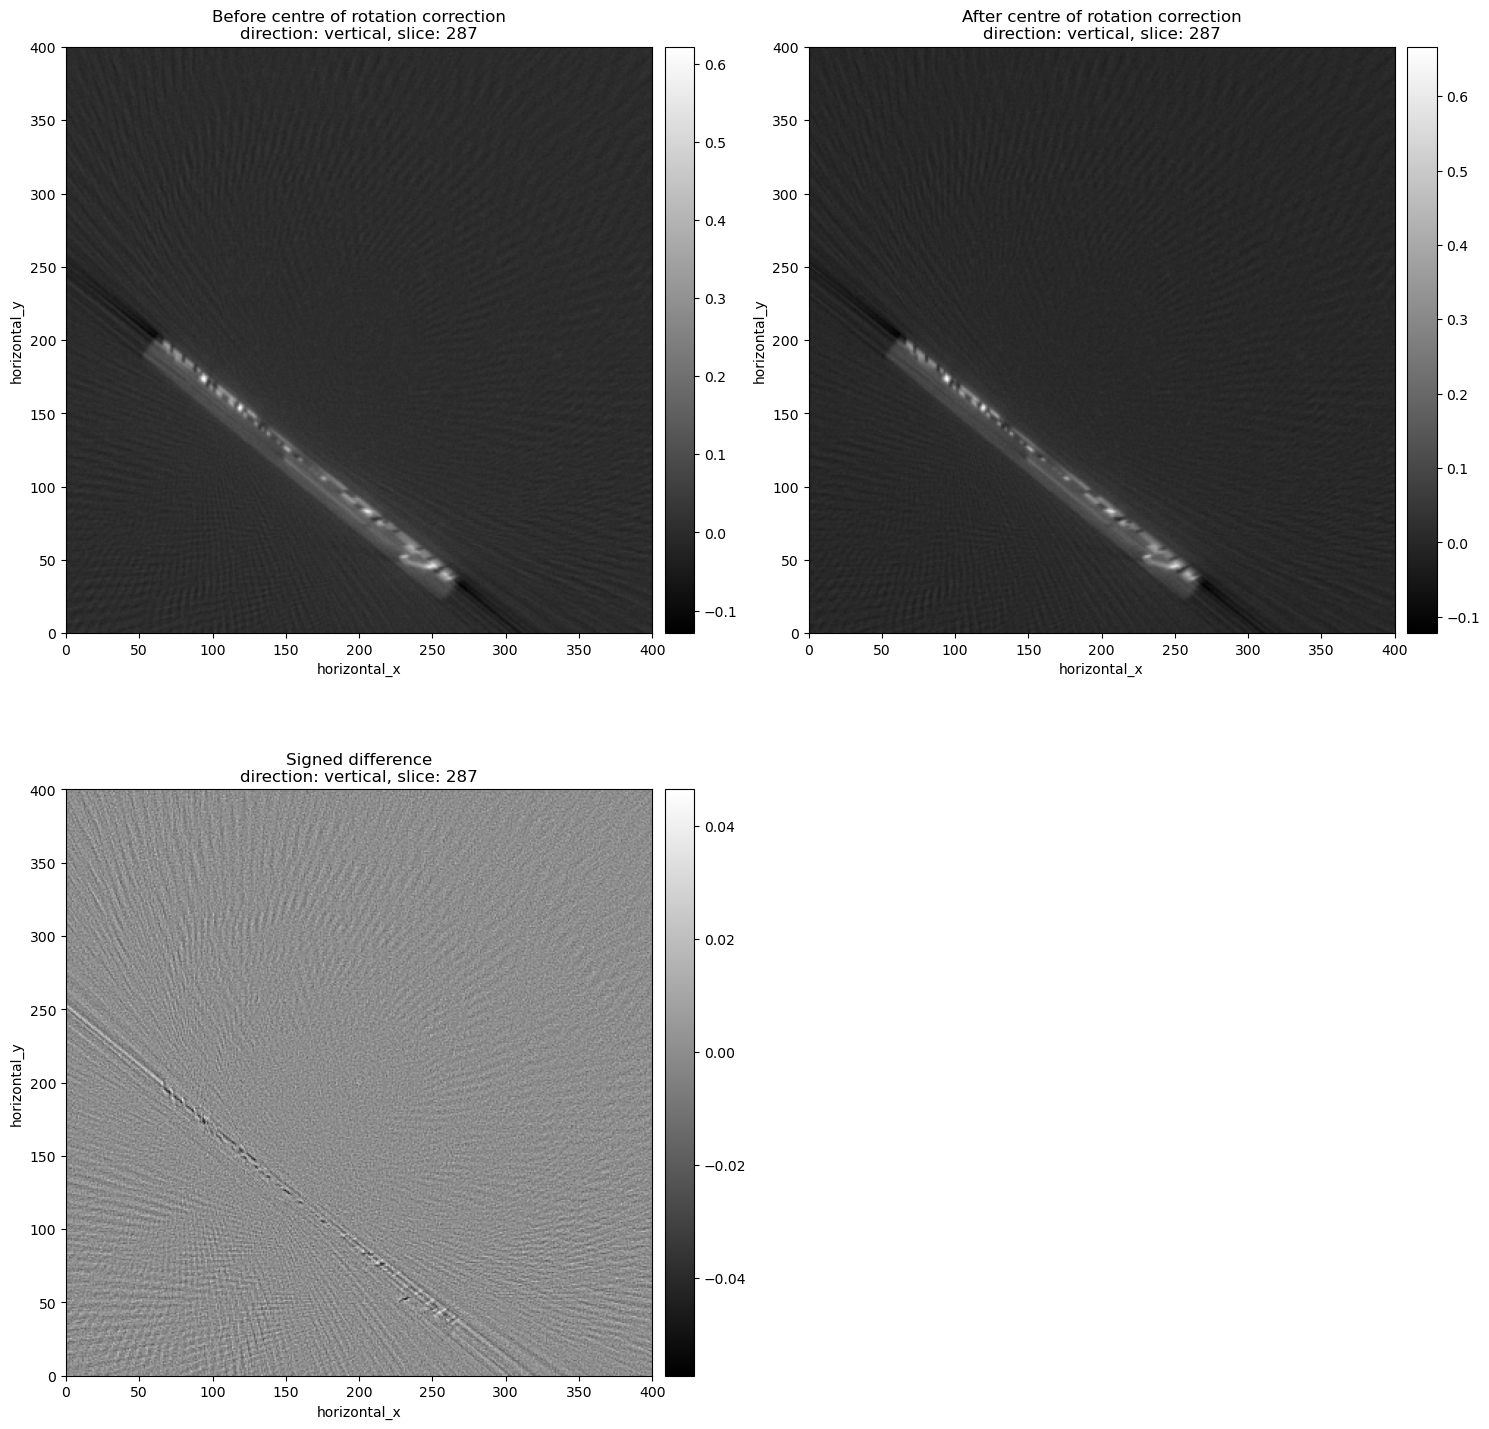

In [19]:
recons_FDK = FDK(data_corr, ig).run(verbose=False)
show2D([reco_before, recons_FDK, reco_before - recons_FDK],
    ['Before centre of rotation correction','After centre of rotation correction','Signed difference'])

Print the geometry to see the rotation axis has been changed

In [20]:
print(data_corr.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -70.34352,   0.     ]
	Rotation axis position: [-0.01267969,  0.        ,  0.        ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 901.39248,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [798 574]
	Pixel size: [0.508 0.508]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [14.332703  , 12.332336  , 10.331955  ,  8.331589  ,  6.3312225 ,
  4.330841  ,  2.3304749 ,  0.33010864, -1.6702576 , -3.670639  ]
	Angles 170-179 in degrees: [-325.73038, -327.73074, -329.7311 , -331.73148, -333.7318 , -335.73218,
 -337.7326 , -339.73297, -341.73334, -343.7337 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


Alternatively manually enter a pixel offset.

In [21]:
# pixel_offset = ???
# data_corr.geometry.set_centre_of_rotation(pixel_offset, distance_units='pixels')

In [22]:
from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.functions import IndicatorBox



Next, we create our simulated tomographic data by projecting our noiseless phantom to the acquisition space. Using the image geometry ig and acquisition geometry ag, we define the ProjectionOperator.


In [23]:
# set the backend for FBP and the ProjectionOperator
device = 'gpu'

In [24]:
# Create projection operator using Astra-Toolbox.
data_corr.reorder('astra')
A = ProjectionOperator(ig, data_corr.geometry, device)

In [25]:
# initial estimate - zero array in this case 
initial = ig.allocate(0)

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=data_corr,
            update_objective_interval = 1 )

In [26]:
cgls_number_of_iteration_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

HBox([Label('Number of iterations (CGLS):'), cgls_number_of_iteration_slider])

In [27]:
# run N interations
cgls.run(cgls_number_of_iteration_slider.value, callbacks=[callbacks.TextProgressCallback()])

     0/25         ?it/s
     1/25      1.19it/s, objective=+4.750e+05
     2/25      1.20it/s, objective=+2.359e+05
     3/25      1.21it/s, objective=+1.444e+05
     4/25      1.22it/s, objective=+1.176e+05
     5/25      1.22it/s, objective=+9.448e+04
     6/25      1.21it/s, objective=+8.237e+04
     7/25      1.20it/s, objective=+7.571e+04
     8/25      1.20it/s, objective=+7.012e+04
     9/25      1.20it/s, objective=+6.740e+04
    10/25      1.19it/s, objective=+6.531e+04
    11/25      1.20it/s, objective=+6.391e+04
    12/25      1.20it/s, objective=+6.284e+04
    13/25      1.21it/s, objective=+6.199e+04
    14/25      1.21it/s, objective=+6.150e+04
    15/25      1.21it/s, objective=+6.097e+04
    16/25      1.21it/s, objective=+6.066e+04
    17/25      1.21it/s, objective=+6.035e+04
    18/25      1.22it/s, objective=+6.015e+04
    19/25      1.22it/s, objective=+5.998e+04
    20/25      1.21it/s, objective=+5.983e+04
    21/25      1.19it/s, objective=+5.971e+04
    22/25 

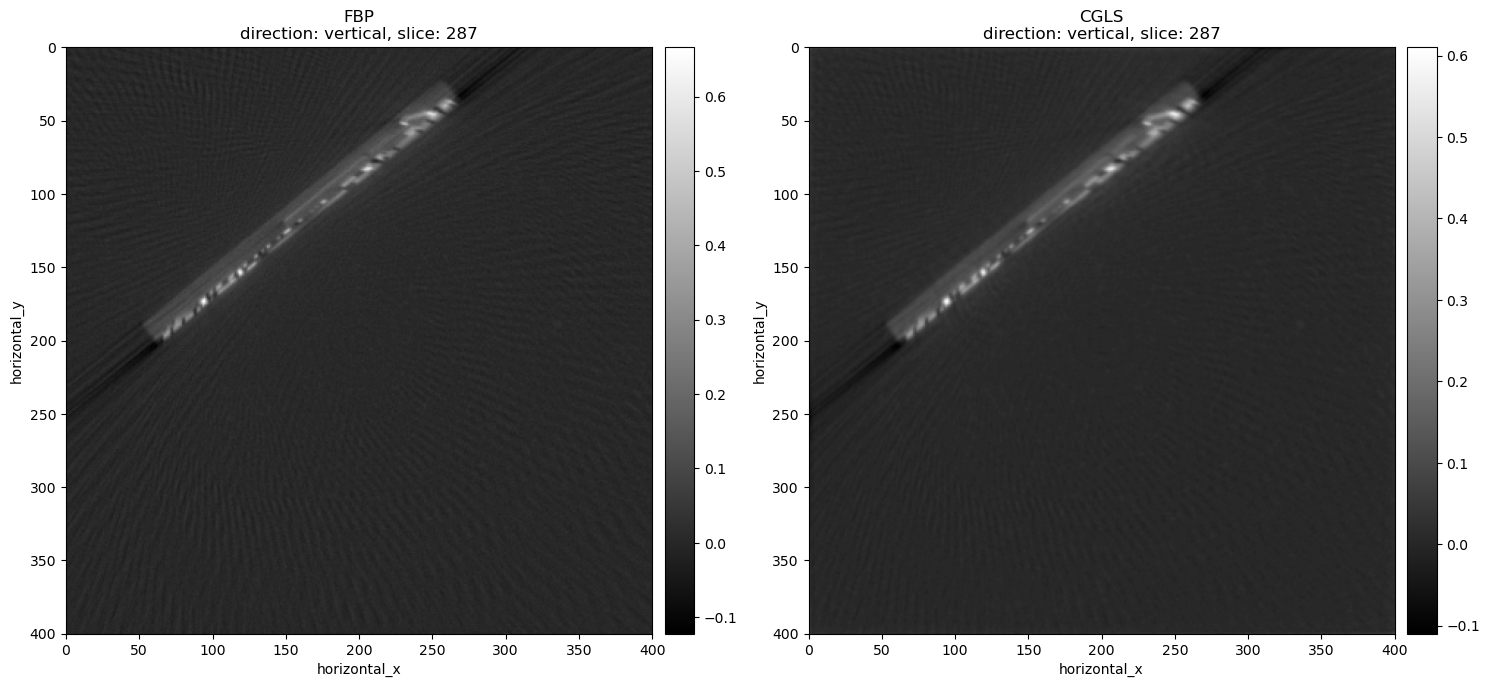

In [29]:
# get and visualise the results
recon_CGLS = cgls.solution

show2D([recons_FDK, recon_CGLS], ['FBP', 'CGLS'], \
       num_cols=3, size=(15,10), origin='upper-left')

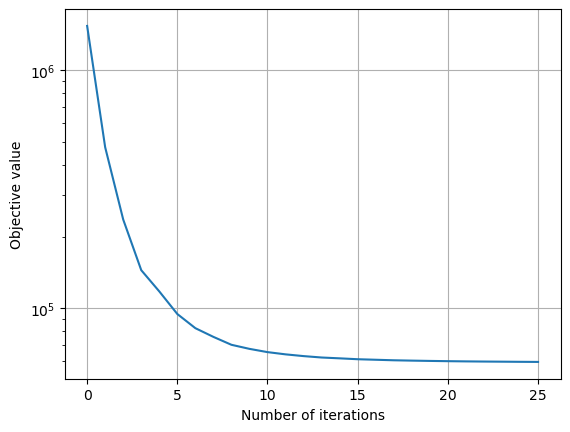

In [30]:
plt.plot(cgls.objective)
plt.gca().set_yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')
plt.grid()


Constrained reconstruction

Perhaps the most intuitive constraint one can enforce on reconstructed data is the non-negativity constraint. The image data we are reconstructing is the linear attenuation coefficient of the material, so intuitively this cannot have a negative value. Here we employ the SIRT algorithm, an algebraic iterative method for a particular weighted least-squares problem which in addition accepts certain convex constraints such as a non-negativity constraint. As with CGLS, it exhibits semi-convergence, however tends to require more iterations. We enforce box constraints (lower and upper bounds) with the IndicatorBox function.


In [31]:
constraint = IndicatorBox(lower=0)

sirt = SIRT(initial=initial, operator=A, data=data_corr, lower=0.0)
sirt.update_objective_interval = 1

/home/fpvidal/miniconda3/envs/CCPi-Users-NXCT-Manchester/lib/python3.10/site-packages/cil/framework/framework.py:3097: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )


In [32]:
sirt_number_of_iteration_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

HBox([Label('Number of iterations (SIRT):'), sirt_number_of_iteration_slider])

In [33]:
# run N interations
sirt.run(sirt_number_of_iteration_slider.value, callbacks=[callbacks.TextProgressCallback()])

     0/50         ?it/s
     1/50      1.13it/s, objective=+3.928e+07
     2/50      1.16it/s, objective=+3.879e+07
     3/50      1.19it/s, objective=+3.847e+07
     4/50      1.18it/s, objective=+3.826e+07
     5/50      1.16it/s, objective=+3.810e+07
     6/50      1.18it/s, objective=+3.798e+07
     7/50      1.18it/s, objective=+3.789e+07
     8/50      1.19it/s, objective=+3.782e+07
     9/50      1.18it/s, objective=+3.776e+07
    10/50      1.17it/s, objective=+3.772e+07
    11/50      1.18it/s, objective=+3.768e+07
    12/50      1.18it/s, objective=+3.765e+07
    13/50      1.18it/s, objective=+3.762e+07
    14/50      1.19it/s, objective=+3.760e+07
    15/50      1.19it/s, objective=+3.759e+07
    16/50      1.19it/s, objective=+3.757e+07
    17/50      1.20it/s, objective=+3.756e+07
    18/50      1.19it/s, objective=+3.756e+07
    19/50      1.18it/s, objective=+3.755e+07
    20/50      1.18it/s, objective=+3.754e+07
    21/50      1.18it/s, objective=+3.754e+07
    22/50 

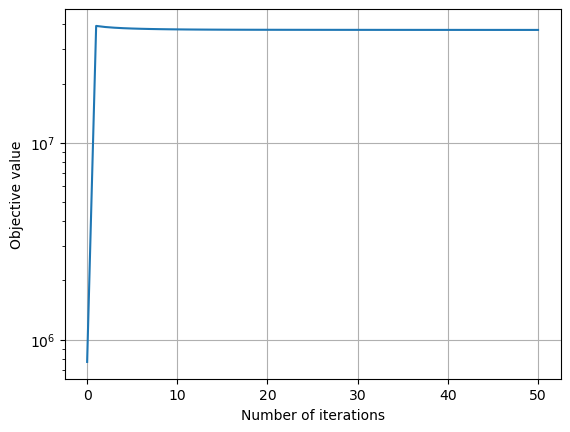

In [35]:
plt.plot(sirt.objective)
plt.gca().set_yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')
plt.grid()

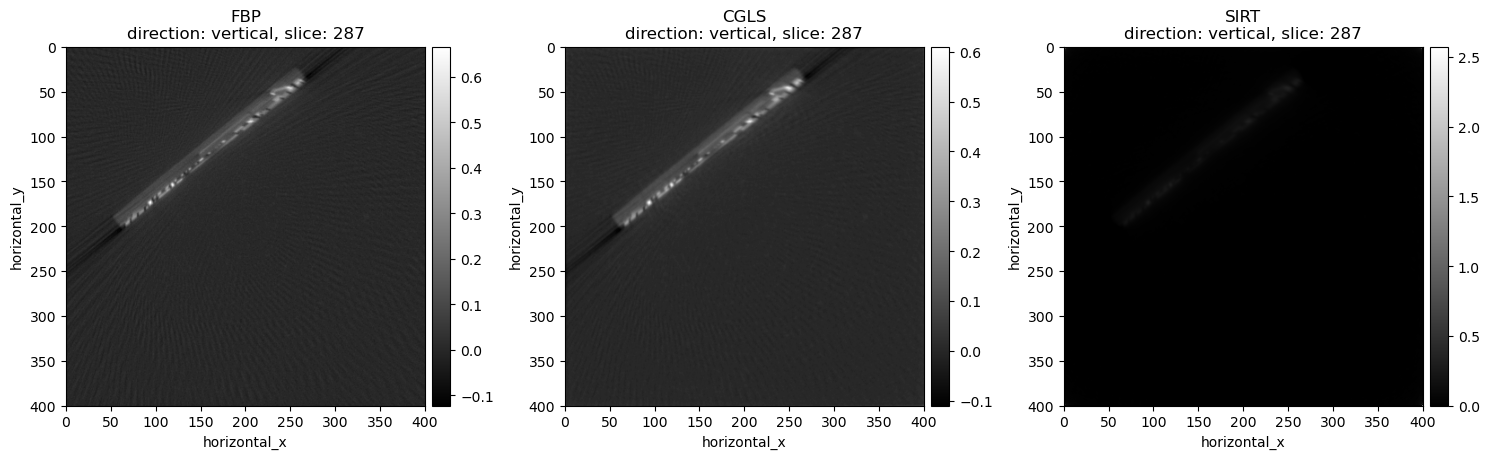

In [36]:
# get and visualise the results
recon_SIRT = sirt.solution

show2D([recons_FDK, recon_CGLS, recon_SIRT], ['FBP', 'CGLS', 'SIRT'], \
       num_cols=3, size=(15,10), origin='upper-left')

In [37]:
raise UserWarning('Exit Early')

UserWarning: Exit Early

##### Crop the data

In [ ]:
# data_before = data_slice.copy()

# processor = Slicer(roi = {'horizontal':(500,2100,1)})
# processor.set_input(data_slice)
# data_slice = processor.get_output()

# show2D([data_before, data_slice], title=['Before cropping', 'After cropping'])


Compare the reconstruction

In [ ]:
# reco = FBP(data_slice).run(verbose=False)
# reco.apply_circular_mask(0.9)

# show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

In [ ]:
# plt.plot(reco_before.array[1100,1100:1200])
# plt.plot(reco.array[1100,1100:1200])
# plt.xlabel('Horizontal x (pixels)')
# plt.ylabel('Intensity')
# plt.legend(['Before phase retrieval','After phase retrieval'])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [ ]:
# data_before = data_slice.copy()
# reco_before = reco.copy()

As above, we can loop through different parameters and view the reconstructions with islicer

In [ ]:
array_list = []
array_list.append(reco.array)
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    processor = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)
    processor.set_input(data_corr)
    temp_data = processor.get_output()
    reco = FDK(temp_data, ig).run(verbose=False)
    array_list.append(reco.array[1])

In [ ]:
temp = []

for i in range(len(array_list)):
    show2D(array_list[i][1])

In [ ]:
DC = DataContainer(np.stack(temp, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)


There's a ring visible at (700-1100, 700-1100). Cycle through the slices to see how well it is removed

In [ ]:
islicer(DC, slice_number=0)


Choose the preferred ring removal method and apply it to the data 

In [ ]:
best_snr = 5
data_slice = rem.remove_all_stripe(data_before.as_array(), best_snr, 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Save the processed data

Once we've happy with the reconstruction save the processed data as TIFF

In [ ]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()